In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    s = sigmoid(x)
    return s * (1 - s)

def cross_entropy_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

In [ ]:
df = pd.read_csv("weather_forecast_data.csv")
X = df.drop('Rain', axis=1).values
y = LabelEncoder().fit_transform(df['Rain'])
y = y.reshape(-1, 1)
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
df.head()

,Temperature,Humidity,Wind_Speed,Cloud_Cover,Pressure,Rain
0,23.720338,89.592641,7.335604,50.501694,1032.378759,rain
1,27.879734,46.489704,5.952484,4.990053,992.614190,no rain
2,25.069084,83.072843,1.371992,14.855784,1007.231620,no rain
3,23.622080,74.367758,7.050551,67.255282,982.632013,rain
4,20.591370,96.858822,4.643921,47.676444,980.825142,no rain


In [ ]:
X_train_full, X_temp, y_train_full, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
def initialize_parameters(layer_sizes):
    np.random.seed(42)
    parameters = {}
    for l in range(1, len(layer_sizes)):
        parameters[f"W{l}"] = np.random.randn(layer_sizes[l-1], layer_sizes[l]) * 0.01
        parameters[f"b{l}"] = np.zeros((1, layer_sizes[l]))
    return parameters

def forward_propagation(X, parameters, num_layers):
    cache = {"A0": X}
    for l in range(1, num_layers + 1):
        cache[f"Z{l}"] = cache[f"A{l-1}"] @ parameters[f"W{l}"] + parameters[f"b{l}"]
        cache[f"A{l}"] = sigmoid(cache[f"Z{l}"])
    return cache

def compute_loss(y_true, y_pred):
    return cross_entropy_loss(y_true, y_pred)

def backward_propagation(y_true, parameters, cache, num_layers):
    grads = {}
    m = y_true.shape[0]
    dA = -(np.divide(y_true, cache[f"A{num_layers}"]) - np.divide(1 - y_true, 1 - cache[f"A{num_layers}"]))

    for l in reversed(range(1, num_layers + 1)):
        dZ = dA * sigmoid_deriv(cache[f"Z{l}"])
        grads[f"dW{l}"] = cache[f"A{l-1}"].T @ dZ / m
        grads[f"db{l}"] = np.sum(dZ, axis=0, keepdims=True) / m
        dA = dZ @ parameters[f"W{l}"].T
    return grads

def update_parameters(parameters, grads, lr, num_layers):
    for l in range(1, num_layers + 1):
        parameters[f"W{l}"] -= lr * grads[f"dW{l}"]
        parameters[f"b{l}"] -= lr * grads[f"db{l}"]
    return parameters

In [ ]:
layer_sizes = [X_train_full.shape[1], 8, 4, 1]  # Example: 2 hidden layers [8, 4]
epochs = 1000
lr = 0.01
parameters = initialize_parameters(layer_sizes)
num_layers = len(layer_sizes) - 1

train_losses = []
val_losses = []

for epoch in range(epochs):
    cache = forward_propagation(X_train_full, parameters, num_layers)
    y_pred_train = cache[f"A{num_layers}"]
    train_loss = compute_loss(y_train_full, y_pred_train)

    cache_val = forward_propagation(X_val, parameters, num_layers)
    y_pred_val = cache_val[f"A{num_layers}"]
    val_loss = compute_loss(y_val, y_pred_val)

    grads = backward_propagation(y_train_full, parameters, cache, num_layers)
    parameters = update_parameters(parameters, grads, lr, num_layers)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

Epoch 100/1000 - Train Loss: 0.5181 - Val Loss: 0.5049
Epoch 200/1000 - Train Loss: 0.4474 - Val Loss: 0.4257
Epoch 300/1000 - Train Loss: 0.4162 - Val Loss: 0.3887
Epoch 400/1000 - Train Loss: 0.4012 - Val Loss: 0.3698
Epoch 500/1000 - Train Loss: 0.3937 - Val Loss: 0.3593
Epoch 600/1000 - Train Loss: 0.3897 - Val Loss: 0.3532
Epoch 700/1000 - Train Loss: 0.3875 - Val Loss: 0.3495
Epoch 800/1000 - Train Loss: 0.3863 - Val Loss: 0.3471
Epoch 900/1000 - Train Loss: 0.3856 - Val Loss: 0.3456
Epoch 1000/1000 - Train Loss: 0.3852 - Val Loss: 0.3445


In [ ]:
def evaluate(X, y, parameters, num_layers):
    cache = forward_propagation(X, parameters, num_layers)
    y_pred_prob = cache[f"A{num_layers}"]
    y_pred = (y_pred_prob > 0.5).astype(int)
    return y_pred, y_pred_prob

In [ ]:
y_pred_test, y_pred_prob_test = evaluate(X_test, y_test, parameters, num_layers)

print("\nTest Set Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_test))
print("Precision:", precision_score(y_test, y_pred_test, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_test))
print("F1 Score:", f1_score(y_test, y_pred_test))


Test Set Evaluation:
Accuracy: 0.872
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


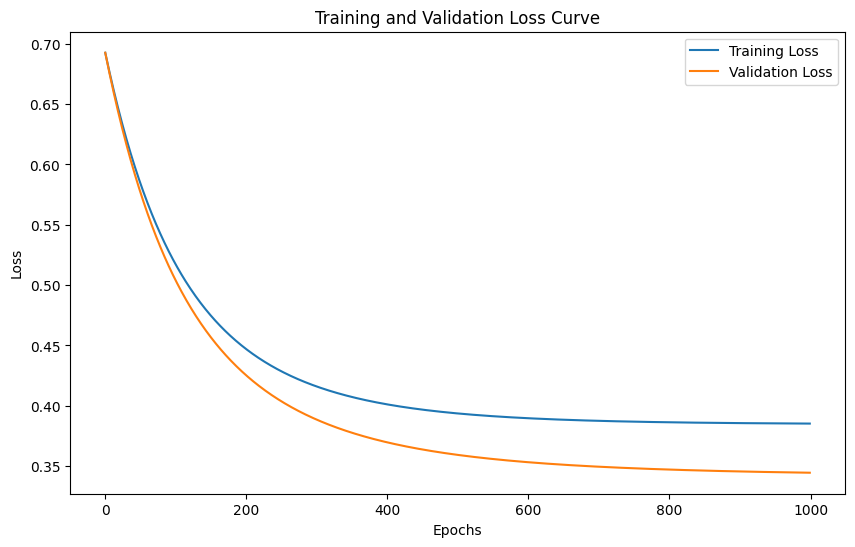

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()